In [ ]:
# RESTART RUNTIME after running this cell!
!pip install -q transformers==4.36.2 datasets==2.17.1 nltk==3.8.1


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.8/126.8 kB 8.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.2/8.2 MB 129.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 536.7/536.7 kB 40.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 81.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 166.4/166.4 kB 17.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 110.5 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
textblob 0.19.0 requires nltk>=3.9, but you have nltk 3.8.1 which is incompatible.
gcsfs 2025.3.0 requires fsspec==2025.3.0, but you have fsspec 2023.10.0 which is incompatible.
sentence-transformers 5.1.0 requires transformers<5.0.0,>=4.41.0, but you have transformers 4.36.2 which is incompatible.


In [ ]:
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import BartTokenizer, BartForConditionalGeneration
from transformers.optimization import AdamW  # ✅ FIXED
from sklearn.model_selection import train_test_split
from nltk.translate.bleu_score import corpus_bleu
import matplotlib.pyplot as plt
from tqdm import tqdm
import os


/usr/local/lib/python3.12/dist-packages/transformers/utils/generic.py:441: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  _torch_pytree._register_pytree_node(
/usr/local/lib/python3.12/dist-packages/transformers/utils/generic.py:309: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  _torch_pytree._register_pytree_node(
/usr/local/lib/python3.12/dist-packages/transformers/utils/generic.py:309: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  _torch_pytree._register_pytree_node(


In [ ]:
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [ ]:
import pandas as pd

df = pd.read_csv("cleaned_data.csv")
print(df.columns.tolist())


['ID', 'Hindi', 'Konkani']


In [ ]:
# Strip spaces and lowercase the column names
df.columns = df.columns.str.strip().str.lower()

# Now check
print(df.columns.tolist())




['id', 'hindi', 'konkani']


In [ ]:
df = df.dropna(subset=['id', 'hindi', 'konkani'])
df.head()


,id,hindi,konkani
0,hhd1,ताजा साँसें और चमचमाते दाँत आपके व्यक्तित्व को...,ताजो स्वास आनी चकचकीत दांत तुमचें व्यक्तीमत्व ...
1,hhd2,दाँतों से आपका आत्मविश्‍वास भी बढ़ता है ।,दांत आशिल्ल्यान तुमचो आत्मविश्वासय वाडटा .
2,hhd3,हमारे मसूढ़ों और दाँतों के बीच बैक्टीरिया मौजू...,आमच्या हड्ड्यां आनी दांतां मदीं बॅक्टेरिया आसत...
3,hhd4,ये दाँतों को गंदा और साँसों को बदबूदार बना देत...,त्यो दांत बुरशे आनी स्वास घाणयारो करतात .
4,hhd5,यहाँ दिए कुछ आसान नुस्खों की मदद से आप अपने दा...,हांगा दिल्ल्या कांय सोंप्या सुचोवण्यांच्या आदा...


In [ ]:
#Train/Test Split


from sklearn.model_selection import train_test_split

# Set source and target
source_lang = "hindi"
target_lang = "konkani"

# Create train/val split (90/10)
train_texts, val_texts = train_test_split(df, test_size=0.1, random_state=42)

print(f"Train size: {len(train_texts)}, Validation size: {len(val_texts)}")


Train size: 22500, Validation size: 2500


In [ ]:
#Load Tokenizer
from transformers import BartTokenizer

tokenizer = BartTokenizer.from_pretrained("facebook/bart-base")


/usr/local/lib/python3.12/dist-packages/huggingface_hub/file_download.py:945: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

config.json: 0.00B [00:00, ?B/s]

In [ ]:
#Define Custom Dataset
from torch.utils.data import Dataset

class TranslationDataset(Dataset):
    def __init__(self, dataframe, tokenizer, source_col, target_col, max_length=128):
        self.data = dataframe
        self.tokenizer = tokenizer
        self.source_col = source_col
        self.target_col = target_col
        self.max_length = max_length

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        src = str(self.data.iloc[idx][self.source_col])
        tgt = str(self.data.iloc[idx][self.target_col])

        source = self.tokenizer(src, max_length=self.max_length, padding="max_length", truncation=True, return_tensors="pt")
        target = self.tokenizer(tgt, max_length=self.max_length, padding="max_length", truncation=True, return_tensors="pt")

        return {
            'input_ids': source['input_ids'].squeeze(),
            'attention_mask': source['attention_mask'].squeeze(),
            'labels': target['input_ids'].squeeze()
        }


In [ ]:
#Create DataLoaders
from torch.utils.data import DataLoader

train_dataset = TranslationDataset(train_texts, tokenizer, source_lang, target_lang)
val_dataset = TranslationDataset(val_texts, tokenizer, source_lang, target_lang)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=8)


In [ ]:
#Define BART Model + Optimizer
import torch
from transformers import BartForConditionalGeneration

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = BartForConditionalGeneration.from_pretrained("facebook/bart-base").to(device)

optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5)


model.safetensors:   0%|          | 0.00/558M [00:00<?, ?B/s]

In [ ]:
#Training Loop
from tqdm import tqdm
import torch.nn as nn

num_epochs = 15
train_losses, val_losses = [], []

for epoch in range(num_epochs):
    model.train()
    total_train_loss = 0

    for batch in tqdm(train_loader, desc=f"Epoch {epoch + 1} - Training"):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        total_train_loss += loss.item()

    avg_train_loss = total_train_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    # Validation
    model.eval()
    total_val_loss = 0

    with torch.no_grad():
        for batch in tqdm(val_loader, desc="Validating"):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss
            total_val_loss += loss.item()

    avg_val_loss = total_val_loss / len(val_loader)
    val_losses.append(avg_val_loss)

    print(f"Epoch {epoch + 1} => Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}")
    torch.save(model.state_dict(), f"bart_epoch_{epoch+1}.pt")


Validating: 100%|██████████| 313/313 [00:29<00:00, 10.50it/s]


Epoch 1 => Train Loss: 0.5759, Val Loss: 0.4364


Validating: 100%|██████████| 313/313 [00:29<00:00, 10.50it/s]


Epoch 2 => Train Loss: 0.4534, Val Loss: 0.3680


Validating: 100%|██████████| 313/313 [00:29<00:00, 10.50it/s]


Epoch 3 => Train Loss: 0.3845, Val Loss: 0.3187


Validating: 100%|██████████| 313/313 [00:32<00:00,  9.70it/s]


Epoch 4 => Train Loss: 0.3390, Val Loss: 0.2939


Validating: 100%|██████████| 313/313 [00:29<00:00, 10.49it/s]


Epoch 5 => Train Loss: 0.3074, Val Loss: 0.2770


Validating: 100%|██████████| 313/313 [00:29<00:00, 10.48it/s]


Epoch 6 => Train Loss: 0.2813, Val Loss: 0.2645


Validating: 100%|██████████| 313/313 [00:29<00:00, 10.50it/s]


Epoch 7 => Train Loss: 0.2612, Val Loss: 0.2532


Validating: 100%|██████████| 313/313 [00:29<00:00, 10.50it/s]


Epoch 8 => Train Loss: 0.2437, Val Loss: 0.2434


Validating: 100%|██████████| 313/313 [00:29<00:00, 10.49it/s]


Epoch 9 => Train Loss: 0.2283, Val Loss: 0.2411


Validating: 100%|██████████| 313/313 [00:29<00:00, 10.50it/s]


Epoch 10 => Train Loss: 0.2156, Val Loss: 0.2322


Validating: 100%|██████████| 313/313 [00:29<00:00, 10.50it/s]


Epoch 11 => Train Loss: 0.2034, Val Loss: 0.2263


Validating: 100%|██████████| 313/313 [00:29<00:00, 10.51it/s]


Epoch 12 => Train Loss: 0.1931, Val Loss: 0.2268


Validating: 100%|██████████| 313/313 [00:29<00:00, 10.49it/s]


Epoch 13 => Train Loss: 0.1837, Val Loss: 0.2264


Validating: 100%|██████████| 313/313 [00:29<00:00, 10.51it/s]


Epoch 14 => Train Loss: 0.1746, Val Loss: 0.2212


Validating: 100%|██████████| 313/313 [00:29<00:00, 10.50it/s]


Epoch 15 => Train Loss: 0.1663, Val Loss: 0.2222


In [ ]:
#Save Checkpoint
model.save_pretrained("bart-hindi-konkani-pos")
tokenizer.save_pretrained("bart-hindi-konkani-pos")


('bart-hindi-konkani-pos/tokenizer_config.json',
 'bart-hindi-konkani-pos/special_tokens_map.json',
 'bart-hindi-konkani-pos/vocab.json',
 'bart-hindi-konkani-pos/merges.txt',
 'bart-hindi-konkani-pos/added_tokens.json')

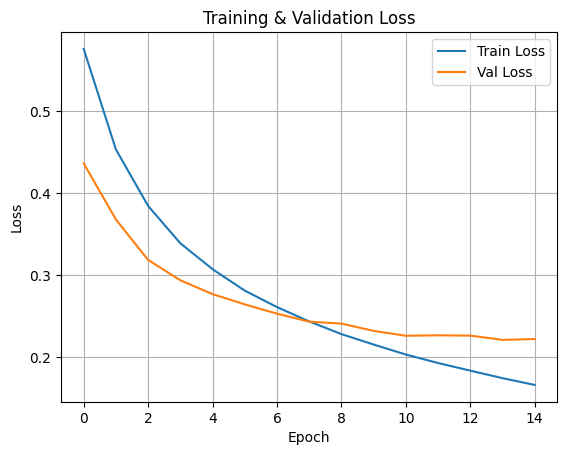

In [ ]:
#Plot Training vs Validation Loss
import matplotlib.pyplot as plt
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training & Validation Loss")
plt.legend()
plt.grid(True)
plt.savefig("loss_plot.png")
plt.show()

In [ ]:
!pip install --upgrade nltk


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 59.1 MB/s eta 0:00:00
  Attempting uninstall: nltk
    Found existing installation: nltk 3.8.1
    Uninstalling nltk-3.8.1:
      Successfully uninstalled nltk-3.8.1


In [ ]:
from fractions import Fraction as OrigFraction

class Fraction(OrigFraction):
    def __new__(cls, *args, **kwargs):
        kwargs.pop('_normalize', None)
        return super().__new__(cls, *args, **kwargs)

import nltk.translate.bleu_score
nltk.translate.bleu_score.Fraction = Fraction


In [ ]:
#BLEU Score Evaluation
from nltk.translate.bleu_score import corpus_bleu

def evaluate_bleu(model, dataloader, tokenizer):
    model.eval()
    predictions, references = [], []

    with torch.no_grad():
        for batch in tqdm(dataloader, desc="Evaluating"):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels']

            outputs = model.generate(input_ids=input_ids, attention_mask=attention_mask, max_length=128)
            preds = [tokenizer.decode(g, skip_special_tokens=True) for g in outputs]
            refs = [tokenizer.decode(t, skip_special_tokens=True) for t in labels]

            predictions.extend(preds)
            references.extend([[ref.split()] for ref in refs])  # BLEU expects list of lists

    score = corpus_bleu(references, [pred.split() for pred in predictions])
    return score

bleu_score = evaluate_bleu(model, val_loader, tokenizer)
print(f"BLEU Score: {bleu_score:.4f}")


Evaluating: 100%|██████████| 313/313 [10:42<00:00,  2.05s/it]

BLEU Score: 0.1045


In [ ]:
!pip install bert-score


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.1/61.1 kB 5.9 MB/s eta 0:00:00


In [ ]:
import torch
from tqdm import tqdm
from bert_score import score as bert_score

def evaluate_bertscore(model, dataloader, tokenizer, device="cuda"):
    model.eval()
    predictions, references = [], []

    with torch.no_grad():
        for batch in tqdm(dataloader, desc="Evaluating with BERTScore"):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels']

            outputs = model.generate(input_ids=input_ids, attention_mask=attention_mask, max_length=128)
            preds = [tokenizer.decode(g, skip_special_tokens=True) for g in outputs]
            refs = [tokenizer.decode(t, skip_special_tokens=True) for t in labels]

            predictions.extend(preds)
            references.extend(refs)

    P, R, F1 = bert_score(predictions, references, lang="en", verbose=True)
    return {
        "precision": P.mean().item(),
        "recall": R.mean().item(),
        "f1": F1.mean().item()
    }

bertscore_results = evaluate_bertscore(model, val_loader, tokenizer)
print("BERTScore:", bertscore_results)


Evaluating with BERTScore: 100%|██████████| 313/313 [10:47<00:00,  2.07s/it]
/usr/local/lib/python3.12/dist-packages/huggingface_hub/file_download.py:945: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/482 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.42G [00:00<?, ?B/s]

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


  0%|          | 0/78 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/40 [00:00<?, ?it/s]

done in 74.40 seconds, 33.60 sentences/sec
BERTScore: {'precision': 0.9395110607147217, 'recall': 0.9435907006263733, 'f1': 0.9414917230606079}


In [ ]:
!pip install rouge-score


  Preparing metadata (setup.py) ... done
  Created wheel for rouge-score: filename=rouge_score-0.1.2-py3-none-any.whl size=24934 sha256=53de1491bfdd59aa71e125cdf2cb5fd39fbe74c8de9bcdf55c96acf094655568
  Stored in directory: /root/.cache/pip/wheels/85/9d/af/01feefbe7d55ef5468796f0c68225b6788e85d9d0a281e7a70
Successfully built rouge-score


In [ ]:
from rouge_score import rouge_scorer
from tqdm import tqdm
import torch

def evaluate_rouge(model, dataloader, tokenizer, device="cuda"):
    model.eval()
    predictions, references = [], []

    with torch.no_grad():
        for batch in tqdm(dataloader, desc="Evaluating with ROUGE"):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels']

            outputs = model.generate(input_ids=input_ids, attention_mask=attention_mask, max_length=128)
            preds = [tokenizer.decode(g, skip_special_tokens=True) for g in outputs]
            refs = [tokenizer.decode(t, skip_special_tokens=True) for t in labels]

            predictions.extend(preds)
            references.extend(refs)

    scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)
    scores = {"rouge1": [], "rouge2": [], "rougeL": []}

    for ref, pred in zip(references, predictions):
        s = scorer.score(ref, pred)
        for k in scores.keys():
            scores[k].append(s[k].fmeasure)  # can also use precision/recall

    avg_scores = {k: sum(v) / len(v) for k, v in scores.items()}
    return avg_scores

rouge_scores = evaluate_rouge(model, val_loader, tokenizer)
print("ROUGE Scores:", rouge_scores)


Evaluating with ROUGE: 100%|██████████| 313/313 [10:43<00:00,  2.06s/it]

ROUGE Scores: {'rouge1': 0.023822222222222224, 'rouge2': 0.008742857142857142, 'rougeL': 0.023822222222222224}


In [ ]:
!pip install evaluate


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 8.0 MB/s eta 0:00:00


In [ ]:
!pip install sacrebleu


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.8/51.8 kB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.1/104.1 kB 10.1 MB/s eta 0:00:00


In [ ]:
import torch
from tqdm import tqdm

def collect_predictions_and_references(model, dataloader, tokenizer, device="cuda"):
    model.eval()
    predictions, references = [], []

    with torch.no_grad():
        for batch in tqdm(dataloader, desc="Collecting predictions"):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels']

            outputs = model.generate(input_ids=input_ids,
                                     attention_mask=attention_mask,
                                     max_length=128,
                                     num_beams=4,  # better quality than greedy
                                     no_repeat_ngram_size=2,
                                     early_stopping=True)

            preds = [tokenizer.decode(g, skip_special_tokens=True) for g in outputs]
            refs = [tokenizer.decode(t, skip_special_tokens=True) for t in labels]

            predictions.extend(preds)
            references.extend(refs)

    return predictions, references

# Run this once
predictions, references = collect_predictions_and_references(model, val_loader, tokenizer)


In [ ]:
import evaluate

chrf = evaluate.load("chrf")
results = chrf.compute(predictions=predictions, references=references)
print("chrF:", results)


chrF: {'score': 16.445763613630962, 'char_order': 6, 'word_order': 0, 'beta': 2}


In [ ]:
outputs = model.generate(
    input_ids=input_ids,
    attention_mask=attention_mask,
    max_length=128,
    num_beams=4,          # beam search improves quality
    no_repeat_ngram_size=2,
    early_stopping=True
)


In [ ]:
import random

def show_sample_predictions(model, dataloader, tokenizer, device="cuda", num_samples=5):
    model.eval()
    samples = []

    with torch.no_grad():
        for batch in dataloader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels']

            outputs = model.generate(input_ids=input_ids, attention_mask=attention_mask, max_length=128)
            preds = [tokenizer.decode(g, skip_special_tokens=True) for g in outputs]
            refs = [tokenizer.decode(t, skip_special_tokens=True) for t in labels]
            inputs = [tokenizer.decode(inp, skip_special_tokens=True) for inp in batch['input_ids']]

            for i in range(len(preds)):
                samples.append((inputs[i], preds[i], refs[i]))

            if len(samples) >= num_samples:
                break

    # Pick a few random samples
    chosen = random.sample(samples, min(num_samples, len(samples)))
    for idx, (inp, pred, ref) in enumerate(chosen):
        print(f"\n--- Sample {idx+1} ---")
        print(f"Input:      {inp}")
        print(f"Prediction: {pred}")
        print(f"Reference:  {ref}")


In [ ]:
show_sample_predictions(model, val_loader, tokenizer, device="cuda", num_samples=5)



--- Sample 1 ---
Input:      ये गोलियाँ बच्चे को दूध पिलाने वाली औरतों को नहीं दी जाती है ।
Prediction: हीं गुळयांच्यो हेर दूद पिवोवपी बायले हाडनात.
Reference:  ह्यो गुळयो भुरग्यांक दूद दिवपी बायलांक दिनात.

--- Sample 2 ---
Input:      पर तुम्हें यह नहीं पता कि इतनी छोटी उम्र में डाइटिंग से कई नुकसान हो सकते हैं ।
Prediction: पूण तुमकां हेंच खबर ना की इतले ल्हान पिराये‍त आाहटीँगाक लावपाचो जाता.
Reference:  पूण तुमकां हें खबर ना की ल्हान पिरायेंत डायटिंगान लुकसाण जावं येता.

--- Sample 3 ---
Input:      रक्‍त नलिकाओं में क्षति के कारण रक्‍त स्राव हो सकता है ।
Prediction: रक्‍ताचे नळयेंत लुकसाणीक लागून रगतस्राव जा वंॕ शकात.
Reference:  रक्ताच्या नळयेंत झरणी जाल्ल्यान रक्तस्राव जावं येता.

--- Sample 4 ---
Input:      अपने रूमाल पर सुगंध का छिड़काव कर सकते हैं, जिससे उपचार कर रहे हैं ।
Prediction: आपल्या सुमालाचेर परमळ सिडकावूंक शकतात, जाणे वायट करीत आसा.
Reference:  आपल्या लेंसाचेर अत्तर शिंपडूंक शकतात, जाका लागून उपचार करतात.

--- Sample 5 ---
Input:      30-35 वर्ष की उम्र के बाद हरेक

In [ ]:
#Test on Unseen Sentences


def translate(text):
    model.eval()
    inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True, max_length=128).to(device)
    outputs = model.generate(**inputs, max_length=128, num_beams=4, early_stopping=True)
    return tokenizer.decode(outputs[0], skip_special_tokens=True)

# Example usage:
hindi_input = "मैं स्कूल जा रही हु"
konkani_output = translate(hindi_input)
print(f"Hindi ➡ Konkani: {konkani_output}")


Hindi ➡ Konkani: हांव शाळून वता.


In [ ]:
import re

def normalize_text(text):
    # 1. Lowercase (if script supports it)
    text = text.lower()

    # 2. Remove extra spaces
    text = re.sub(r"\s+", " ", text).strip()

    # 3. Remove punctuation (optional, depending on task)
    text = re.sub(r"[!\"#$%&'()*+,-./:;<=>?@\[\\\]^_`{|}~]", "", text)

    # 4. Normalize common Unicode issues (NFC form)
    import unicodedata
    text = unicodedata.normalize("NFC", text)

    # 5. Custom spelling corrections / mappings
    spelling_dict = {
        "डाइटिंग": "डायटिंग",
        "लुकसाण": "नुकसान",
        "बायले": "बायल",
        "गुळयो": "गोळियाँ",
        # add more manually as you see mismatches
    }
    for wrong, right in spelling_dict.items():
        text = text.replace(wrong, right)

    return text


# Example usage on dataset
def preprocess_dataset(dataset):
    """dataset = list of (input, output) tuples"""
    cleaned_dataset = []
    for inp, ref in dataset:
        cleaned_inp = normalize_text(inp)
        cleaned_ref = normalize_text(ref)
        cleaned_dataset.append((cleaned_inp, cleaned_ref))
    return cleaned_dataset


# Example
dataset = [
    ("ये गोलियाँ बच्चे को दूध पिलाने वाली औरतों को नहीं दी जाती है ।",
     "ह्यो गुळयो भुरग्यांक दूद दिवपी बायलांक दिनात."),
    ("पर तुम्हें यह नहीं पता कि इतनी छोटी उम्र में डाइटिंग से कई नुकसान हो सकते हैं ।",
     "पूण तुमकां हें खबर ना की ल्हान पिरायेंत डायटिंगान लुकसाण जावं येता.")
]

cleaned_dataset = preprocess_dataset(dataset)
for inp, ref in cleaned_dataset:
    print("Input:", inp)
    print("Reference:", ref, "\n")


Input: ये गोलियाँ बच्चे को दूध पिलाने वाली औरतों को नहीं दी जाती है ।
Reference: ह्यो गोळियाँ भुरग्यांक दूद दिवपी बायलांक दिनात 

Input: पर तुम्हें यह नहीं पता कि इतनी छोटी उम्र में डायटिंग से कई नुकसान हो सकते हैं ।
Reference: पूण तुमकां हें खबर ना की ल्हान पिरायेंत डायटिंगान नुकसान जावं येता 



In [ ]:
import difflib
import re
from collections import Counter

def normalize_text_basic(text):
    """Basic cleanup: lowercase, strip, normalize Unicode."""
    import unicodedata
    text = text.lower().strip()
    text = unicodedata.normalize("NFC", text)
    text = re.sub(r"\s+", " ", text)
    return text

def build_lexical_map(predictions, references, min_ratio=0.8):
    """
    Build candidate lexical correction mapping by comparing tokens
    that are very similar (edit distance).
    """
    pred_tokens = [t for p in predictions for t in normalize_text_basic(p).split()]
    ref_tokens  = [t for r in references for t in normalize_text_basic(r).split()]

    pred_counts = Counter(pred_tokens)
    ref_counts  = Counter(ref_tokens)

    mapping = {}

    for p in pred_counts:
        # Find closest reference token by similarity
        close = difflib.get_close_matches(p, ref_counts.keys(), n=1, cutoff=min_ratio)
        if close:
            ref_word = close[0]
            if p != ref_word:  # avoid identity mapping
                mapping[p] = ref_word

    return mapping

def apply_mapping(text, mapping):
    tokens = normalize_text_basic(text).split()
    corrected = [mapping.get(tok, tok) for tok in tokens]
    return " ".join(corrected)


# Example data
predictions = [
    "ह्यो गुळयो भुरग्यांक दूद दिवपी बायलांक दिनात",
    "पूण तुमकां हें खबर ना की ल्हान पिरायेंत डायटिंगान लुकसाण जावं येता"
]

references = [
    "ह्यो गोळियाँ भुरग्यांक दूद दिवपी बायलांक दिनात",
    "पूण तुमकां हें खबर ना की ल्हान पिरायेंत डायटिंगान नुकसान जावं येता"
]

# Build correction mapping
lex_map = build_lexical_map(predictions, references, min_ratio=0.75)
print("Candidate Mapping:", lex_map)

# Apply to predictions
corrected_preds = [apply_mapping(p, lex_map) for p in predictions]
for p, c, r in zip(predictions, corrected_preds, references):
    print("\nOriginal:", p)
    print("Corrected:", c)
    print("Reference:", r)


Candidate Mapping: {}

Original: ह्यो गुळयो भुरग्यांक दूद दिवपी बायलांक दिनात
Corrected: ह्यो गुळयो भुरग्यांक दूद दिवपी बायलांक दिनात
Reference: ह्यो गोळियाँ भुरग्यांक दूद दिवपी बायलांक दिनात

Original: पूण तुमकां हें खबर ना की ल्हान पिरायेंत डायटिंगान लुकसाण जावं येता
Corrected: पूण तुमकां हें खबर ना की ल्हान पिरायेंत डायटिंगान लुकसाण जावं येता
Reference: पूण तुमकां हें खबर ना की ल्हान पिरायेंत डायटिंगान नुकसान जावं येता


In [ ]:
import difflib
import unicodedata
import re
from collections import Counter, defaultdict
import json

def normalize_text_basic(text):
    """Basic Unicode + spacing normalization."""
    text = text.lower().strip()
    text = unicodedata.normalize("NFC", text)
    text = re.sub(r"\s+", " ", text)
    return text

def build_global_lexical_map(references, min_ratio=0.75, min_freq=2):
    """
    Build lexical normalization dictionary from references.
    - references: list of reference strings
    - min_ratio: similarity threshold for mapping (0.0–1.0)
    - min_freq: minimum frequency for a token to be considered reliable
    """
    ref_tokens = [t for r in references for t in normalize_text_basic(r).split()]
    ref_counts = Counter(ref_tokens)

    mapping = {}

    for word in ref_counts:
        if ref_counts[word] < min_freq:
            continue
        # find words very similar to 'word'
        matches = difflib.get_close_matches(word, ref_counts.keys(), n=3, cutoff=min_ratio)
        for m in matches:
            if m != word:
                # always map less frequent word → more frequent word
                if ref_counts[word] < ref_counts[m]:
                    mapping[word] = m
                else:
                    mapping[m] = word

    return mapping

def apply_mapping(text, mapping):
    tokens = normalize_text_basic(text).split()
    corrected = [mapping.get(tok, tok) for tok in tokens]
    return " ".join(corrected)


In [ ]:
# Example dataset
references = [
    "ह्यो गोळियाँ भुरग्यांक दूद दिवपी बायलांक दिनात",
    "पूण तुमकां हें खबर ना की ल्हान पिरायेंत डायटिंगान नुकसान जावं येता",
    "रक्ताच्या नळयेंत झरणी जाल्ल्यान रक्तस्राव जावं येता"
]

predictions = [
    "ह्यो गुळयो भुरग्यांक दूद दिवपी बायलांक दिनात",
    "पूण तुमकां हें खबर ना की ल्हान पिरायेंत डायटिंगान लुकसाण जावं येता",
    "रक्‍ताचे नळयेंत लुकसाणीक लागून रगतस्राव जा वं शकात"
]

# Build mapping on training references
lex_map = build_global_lexical_map(references, min_ratio=0.75, min_freq=1)
print("Lexical Map:", lex_map)

# Apply to references and predictions
norm_refs = [apply_mapping(r, lex_map) for r in references]
norm_preds = [apply_mapping(p, lex_map) for p in predictions]

for r, p, np in zip(references, predictions, norm_preds):
    print("\nReference:", r)
    print("Prediction:", p)
    print("Corrected Prediction:", np)


Lexical Map: {}

Reference: ह्यो गोळियाँ भुरग्यांक दूद दिवपी बायलांक दिनात
Prediction: ह्यो गुळयो भुरग्यांक दूद दिवपी बायलांक दिनात
Corrected Prediction: ह्यो गुळयो भुरग्यांक दूद दिवपी बायलांक दिनात

Reference: पूण तुमकां हें खबर ना की ल्हान पिरायेंत डायटिंगान नुकसान जावं येता
Prediction: पूण तुमकां हें खबर ना की ल्हान पिरायेंत डायटिंगान लुकसाण जावं येता
Corrected Prediction: पूण तुमकां हें खबर ना की ल्हान पिरायेंत डायटिंगान लुकसाण जावं येता

Reference: रक्ताच्या नळयेंत झरणी जाल्ल्यान रक्तस्राव जावं येता
Prediction: रक्‍ताचे नळयेंत लुकसाणीक लागून रगतस्राव जा वं शकात
Corrected Prediction: रक्‍ताचे नळयेंत लुकसाणीक लागून रगतस्राव जा वं शकात


In [ ]:
with open("lexical_map.json", "w", encoding="utf-8") as f:
    json.dump(lex_map, f, ensure_ascii=False, indent=2)

# Load later
with open("lexical_map.json", "r", encoding="utf-8") as f:
    lex_map = json.load(f)


In [ ]:
import pandas as pd

# Load file
df = pd.read_csv("cleaned_data.csv")

# Show first rows & column names
print("Columns:", df.columns.tolist())
print(df.head())


Columns: ['ID', 'Hindi', 'Konkani']
     ID                                              Hindi  \
0  hhd1  ताजा साँसें और चमचमाते दाँत आपके व्यक्तित्व को...   
1  hhd2          दाँतों से आपका आत्मविश्‍वास भी बढ़ता है ।   
2  hhd3  हमारे मसूढ़ों और दाँतों के बीच बैक्टीरिया मौजू...   
3  hhd4  ये दाँतों को गंदा और साँसों को बदबूदार बना देत...   
4  hhd5  यहाँ दिए कुछ आसान नुस्खों की मदद से आप अपने दा...   

                                             Konkani  
0  ताजो स्वास आनी चकचकीत दांत तुमचें व्यक्तीमत्व ...  
1         दांत आशिल्ल्यान तुमचो आत्मविश्वासय वाडटा .  
2  आमच्या हड्ड्यां आनी दांतां मदीं बॅक्टेरिया आसत...  
3          त्यो दांत बुरशे आनी स्वास घाणयारो करतात .  
4  हांगा दिल्ल्या कांय सोंप्या सुचोवण्यांच्या आदा...  


In [ ]:
import pandas as pd
import difflib
import unicodedata
import re
from collections import Counter

# Basic normalization
def normalize_text_basic(text):
    text = str(text).lower().strip()
    text = unicodedata.normalize("NFC", text)
    text = re.sub(r"\s+", " ", text)
    return text

def build_lexical_map(texts, min_ratio=0.75, min_freq=1):
    tokens = [t for txt in texts for t in normalize_text_basic(txt).split()]
    token_counts = Counter(tokens)

    mapping = {}
    for word in token_counts:
        matches = difflib.get_close_matches(word, token_counts.keys(), n=3, cutoff=min_ratio)
        for m in matches:
            if m != word:
                if token_counts[word] < token_counts[m]:
                    mapping[word] = m
                else:
                    mapping[m] = word
    return mapping

def apply_mapping(text, mapping):
    tokens = normalize_text_basic(str(text)).split()
    corrected = [mapping.get(tok, tok) for tok in tokens]
    return " ".join(corrected)

# Load dataset
df = pd.read_csv("cleaned_data.csv")

# Build mapping from Konkani reference sentences
konkani_texts = df["Konkani"].astype(str).tolist()
lex_map = build_lexical_map(konkani_texts, min_ratio=0.75, min_freq=1)

# Apply normalization
df["Normalized_Konkani"] = df["Konkani"].apply(lambda x: apply_mapping(x, lex_map))

# Save corrected dataset
out_path = "lexically_corrected.csv"
df.to_csv(out_path, index=False, encoding="utf-8")

print("✅ Lexically corrected dataset saved at:", out_path)
